In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
import numpy as np
from torch import nn
import json
from numpy.random import shuffle
import torch
import torch.optim as optim
import os, sys
from time import time
import torch.nn.functional as F

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [13]:
with open('lookup.json') as fl:
    tag_lookup = json.load(fl)
    
with open('word_list.txt') as fl:
    vocab = fl.read().split('\n')

embeds = np.load('word_embeds.npy')
wlookup = { word: index for index, word in enumerate(vocab) }

len(vocab), embeds.shape, len(tag_lookup)

(23625, (23625, 300), 8)

In [45]:
np.max(embeds[wlookup['Japan']]), np.max(embeds[wlookup['Russia']])

(0.376953125, 0.48046875)

In [46]:
with open('eng.train') as fl:
    sents = fl.read().split('\n\n')[1:-1]
    
with open('eng.testa') as fl:
    eval_sents = fl.read().split('\n\n')[1:-1]
    
with open('eng.testb') as fl:
    test_sents = fl.read().split('\n\n')[1:-1]
    
len(sents), len(eval_sents), len(test_sents)

(14986, 3465, 3683)

In [47]:
def load_sent(sent):
    words = sent.split('\n')
    inps = []
    outs = []
    for wordinfo in words:
        word, _, _, tag = wordinfo.split()
        try:
            assert word in wlookup
        except:
            # word not in our known dictionary, so use the unk token
            word = 'unk'
        inps.append(embeds[wlookup[word]])
        hot = np.zeros(len(tag_lookup))
        hot[tag_lookup[tag]] = 1
        outs.append(hot)
    return [np.vstack(inps), np.vstack(outs)]

ins, outs = load_sent(sents[0])
ins.shape, outs.shape

((9, 300), (9, 8))

In [0]:
def getLen(sent):
    words = sent.split('\n')
    return len(words)
train_len = [getLen(sent) for sent in sents]
eval_len = [getLen(sent) for sent in eval_sents]
test_len = [getLen(sent) for sent in test_sents]

In [49]:
BSIZE = 20
train_inds = list(range(len(sents)))
shuffle(train_inds)
train_inds[:10]

[10531, 8622, 5422, 14098, 9483, 2019, 639, 11708, 12437, 14660]

In [0]:
class RNN(nn.Module):
    def __init__(self, insize=300, outsize=8, hsize=128):
        super().__init__()
        
        # TODO: Dropout
        # TODO: nonlinearities
        # TODO: Bidirectional

        self.fc1=nn.Sequential(
             nn.Dropout(p=0.3),
             nn.Linear(hsize*2, hsize),
            
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(hsize, outsize),
            nn.Softmax(dim=-1)
        )

        # FIXME: this is a uni-directional LSTM
       

        self.rnn = nn.LSTM(insize, hsize, 1, batch_first=True, bidirectional=True)

    def forward(self, inputs, seq_lengths, hidden=None):
        dim = inputs.shape
        
        
        hin = torch.nn.utils.rnn.pack_padded_sequence(inputs, seq_lengths, batch_first=True)
        hout, hidden = self.rnn(hin)
        
        hout, _= torch.nn.utils.rnn.pad_packed_sequence(hout, batch_first=True) 
        
        hout = hout.contiguous()
        hout = hout.view(-1, hout.shape[2])
        
        fout = self.fc1(F.relu(hout))
        
        yout = self.fc2(F.relu(fout))
        
        
        yout = yout.view(dim[0], dim[1],-1)
        
        
        return yout, hidden
    
model = RNN().to(device)


criterion = nn.CrossEntropyLoss(reduction='none').cuda()
opt = optim.Adam(model.parameters(), lr=0.0015)


In [0]:
def loss_func(Y_hat, Y, seq_len):
    
    Y =  torch.argmax(Y, dim=2) 
    np_array = Y.cpu().numpy()
    mask = np.zeros_like(np_array)
    for i in range(Y.shape[0]):
        mask[i,:seq_len[i]] = 1    
    
    Y_hat = Y_hat.permute(0,2,1)
    
    l = criterion(Y_hat, Y)
    
    mask = n2t(mask)
    l = l * mask
    mask = mask.cpu().numpy()
    total = int(np.count_nonzero(mask))
    
    l = torch.sum(l)
    l = l / total
    return l

In [70]:
EPS = 20
train_loss = []
eval_loss = []
n2t = lambda narr: torch.from_numpy(narr).to(device).float()

def eval_model(evaldata, data_len, results=False, predictions= False):
    model.eval()
    losses = []
    ypreds = []
    seq_length = data_len
    for i, sent in enumerate(evaldata):
        Xs, Ys = zip(*[load_sent(sent)])
        Xs_len = [seq_length[i]]
        
        Xs, Ys, Xs_len = np.array(Xs), np.array(Ys), np.array(Xs_len)
        Xs, Ys = n2t(Xs), n2t(Ys)
        
        
        
        with torch.no_grad():
            yhat, _ = model(Xs, Xs_len)
            ypreds.append(yhat)
           
            Ys_num = Ys
            
            loss = loss_func(yhat, Ys_num, Xs_len)
            losses.append(loss.item())
    print('Eval: %.4f' % np.mean(losses))
    
    if predictions: 
        return ypreds
    else:
        return np.mean(losses)
    
eval_loss.append(eval_model(eval_sents,eval_len))

Eval: 2.0813


In [71]:

for epoch in range(EPS):
    model.train()
    
    t0 = time()
    batch_loss = []
    for bi in range(0, len(train_inds)-BSIZE, BSIZE):
        inds = train_inds[bi:bi+BSIZE]
        
        inds.sort(key=lambda x: train_len[x], reverse=True)
     
        # TODO: correct formatting for batchsize >1
        Xs, Ys = zip(*[load_sent(sents[ind]) for ind in inds])
      
        Xs_length = [x.shape[0] for x in Xs]
        
        max_seq = np.max(Xs_length)
        
        Xs = list(Xs)
        Xs = [np.vstack((x,np.zeros((max_seq-x.shape[0],300)))) for x in Xs]
        Ys = [np.vstack((y,np.zeros((max_seq-y.shape[0],8)))) for y in Ys]
        
       
        Xs, Ys = np.array(Xs), np.array(Ys)
        
        Xs, Ys = n2t(Xs), n2t(Ys)

        yhat, _ = model(Xs, Xs_length)
        
        Ys_num = Ys

        opt.zero_grad()
        
        loss = loss_func(yhat, Ys_num,Xs_length)
        loss.backward()
        opt.step()

        sys.stdout.write('\r[E%d/%d - B%d/%d] Train: %.4f ' % (
            epoch+1, EPS,
            bi+1, len(train_inds),
            loss.item(),
        ))
        batch_loss.append(loss.item())
    train_loss.append(np.mean(batch_loss))
    sys.stdout.write('(elapsed: %.2fs)\n' % (time() - t0))
    sys.stdout.flush()
    
    loss = eval_model(eval_sents,eval_len)
    eval_loss.append(loss)
        
    # TODO: shuffle train inds
    shuffle(train_inds)

[E1/20 - B14961/14986] Train: 1.4576 (elapsed: 9.79s)
Eval: 1.4884
[E2/20 - B14961/14986] Train: 1.3239 (elapsed: 9.73s)
Eval: 1.3524
[E3/20 - B14961/14986] Train: 1.3067 (elapsed: 10.04s)
Eval: 1.3271
[E4/20 - B14961/14986] Train: 1.2833 (elapsed: 9.74s)
Eval: 1.3200
[E5/20 - B14961/14986] Train: 1.2856 (elapsed: 9.72s)
Eval: 1.3143
[E6/20 - B14961/14986] Train: 1.2849 (elapsed: 9.74s)
Eval: 1.3146
[E7/20 - B14961/14986] Train: 1.2880 (elapsed: 9.72s)
Eval: 1.3135
[E8/20 - B14961/14986] Train: 1.2795 (elapsed: 9.80s)
Eval: 1.3145
[E9/20 - B14961/14986] Train: 1.2831 (elapsed: 10.08s)
Eval: 1.3130
[E10/20 - B14961/14986] Train: 1.3050 (elapsed: 9.74s)
Eval: 1.3121
[E11/20 - B14961/14986] Train: 1.2925 (elapsed: 9.73s)
Eval: 1.3131
[E12/20 - B14961/14986] Train: 1.2962 (elapsed: 9.79s)
Eval: 1.3132
[E13/20 - B14961/14986] Train: 1.2860 (elapsed: 9.76s)
Eval: 1.3125
[E14/20 - B14961/14986] Train: 1.2937 (elapsed: 10.46s)
Eval: 1.3160
[E15/20 - B14961/14986] Train: 1.2785 (elapsed: 9.73s)

LSTM Network is used to predict the NER tags of words given a sentence. To imrove the performance of the given model I have added following things -

1. The batch size was increase to 20. But with this there was a problem that each sentence had different lengths which the model will not accept. Hence, padding was done to make the all sentences have same length. Initally the padding was done such that each sentence will have length equal to length of sentence with maximum words in entire data set. But this did not give the best results
2. CrossEntropy loss criterion was used instead of MSEloss.
3. To over come the problem of different lengths of sentences padding was done batch wise. All sentences in a batch will have same length which would be maximum of the sentences in that batch.
4. As with padded sentences the Network would see a lot of un wanted padded values which are not very useful. So to over come this I used pytorch's pad_packed_sequence.
5. The packing was undone after the LSTM layer.
6. I also added a custom loss function because we dont want to calculate loss on the padded indexes.
7. I passed the sequence directly to the LSTM, made the LSTM bidirectional
8. The output of LSTM was passed through a non linear layer of ReLU
9. The output of ReLU was passed through a Dropout layer (0.3), Linear FC layer (input - 256, output - 128)
10. The above output was passed through a ReLU layer, Dropout layer (0.2), Linear Layer (input - 128, output - 8) and finally Softmax
11. I used the Adam Optimizer, 20 epochs and 0.0015 Learning rate

**Hyper Parameter Tuning Steps**

1. Increased the number of LSTM layers and added dropout within those layers but it did not give better performance (F1 accuracy - 70)

2. The dropout layer was initially made default p=0.5 (F1 accuracy - 71) but reducing it gradually gave better results

3. Without adding non linearity ReLU the F1 accuracy was coming to be 71.5 and adding the non linearity helped improve the accuracy.

4. The learning rate 0.0005, 0.001 and 0.0015 and the accuracy increased for each higher learning rate but reduced for learning rate beyond 0.02

In [0]:
import matplotlib.pyplot as plt

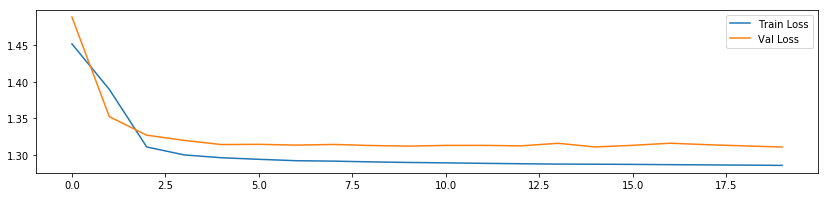

In [73]:
plt.figure(figsize=(14, 3))
plt.plot(train_loss, label = 'Train Loss')
plt.plot(eval_loss[1:], label = 'Val Loss')
plt.legend()
plt.show(); plt.close()

In [74]:
test_results = eval_model(test_sents, test_len, results=True, predictions=True)

Eval: 1.3392


In [0]:
index2tag = { index: tag for tag, index in tag_lookup.items() }
with open('nn.output' , 'w') as fl:
    assert len(test_results) == len(test_sents)
    for ti, (yhat, schunk) in enumerate(zip(test_results, test_sents)):
        yhat = yhat.detach().cpu().numpy()
        for wi, wordinfo in enumerate(schunk.split('\n')):
            word, _, _, tag = wordinfo.split()
            taghat = index2tag[np.argmax(yhat[0, wi, :])]

            fl.write('%s %s %s\n' % (word, taghat, tag))
        fl.write('\n')

In [76]:
!python conlleval.py nn.output 

processed 46665 tokens with 4588 phrases; found: 5648 phrases; correct: 3759.
accuracy:  94.45%; precision:  66.55%; recall:  81.93%; FB1:  73.45
              LOC: precision:  80.28%; recall:  88.56%; FB1:  84.21  1668
             MISC: precision:  68.80%; recall:  77.78%; FB1:  73.02  702
              ORG: precision:  60.93%; recall:  76.78%; FB1:  67.94  1661
              PER: precision:  57.20%; recall:  81.35%; FB1:  67.18  1617


# **STORING RESULTS FOR QUESTION 3**


For question 3 we need the prediction of all sentences in train, eval and test. Hence i calculated the predictions for all three data set and stored it in a file as per the order of AIDA dataset. 

In [77]:
val_results = eval_model(eval_sents,eval_len, results=True, predictions=True) 

Eval: 1.3110


In [78]:
train_results = eval_model(sents, train_len, results=True, predictions=True) 

Eval: 1.2874


In [0]:
index2tag = { index: tag for tag, index in tag_lookup.items() }
with open('entire.output' , 'w') as fl:
    assert len(train_results) == len(sents)
    for ti, (yhat, schunk) in enumerate(zip(train_results, sents)):
        yhat = yhat.detach().cpu().numpy()
        for wi, wordinfo in enumerate(schunk.split('\n')):
            word, _, _, tag = wordinfo.split()
            taghat = index2tag[np.argmax(yhat[0, wi, :])]

            fl.write('%s %s %s\n' % (word, taghat, tag))
        fl.write('\n')

In [0]:
index2tag = { index: tag for tag, index in tag_lookup.items() }
with open('entire.output' , 'a') as fl:
    assert len(val_results) == len(eval_sents)
    for ti, (yhat, schunk) in enumerate(zip(val_results, eval_sents)):
        yhat = yhat.detach().cpu().numpy()
        for wi, wordinfo in enumerate(schunk.split('\n')):
            word, _, _, tag = wordinfo.split()
            taghat = index2tag[np.argmax(yhat[0, wi, :])]

            fl.write('%s %s %s\n' % (word, taghat, tag))
        fl.write('\n')

In [0]:
index2tag = { index: tag for tag, index in tag_lookup.items() }
with open('entire.output' , 'a') as fl:
    assert len(test_results) == len(test_sents)
    for ti, (yhat, schunk) in enumerate(zip(test_results, test_sents)):
        yhat = yhat.detach().cpu().numpy()
        for wi, wordinfo in enumerate(schunk.split('\n')):
            word, _, _, tag = wordinfo.split()
            taghat = index2tag[np.argmax(yhat[0, wi, :])]

            fl.write('%s %s %s\n' % (word, taghat, tag))
        fl.write('\n')